# Problem Set 3

### Before You Start

This problem set is fun but challenging. It's going to involve a good amount of debugging and head-scratching, so try to start sooner rather than later!

This problem set has three parts:

- **Part I**: Experimental Setup
- **Part II**: Nearest Neighbor and Cross-Validation
- **Part III**: Overfitting in Model Selection and Nested Cross Validation

For part I and II we'll consider a regression problem. You should *not* be using any built-in ML libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! For these two first parts we will be working with a modified version of the California Housing Dataset that you can download from bcourses (`cal_housing_data_clean.csv`). Part I will be relatively easy; Part II will take more time.

For part III we'll consider a classification problem. You'll be able to use Python ML built-in libraries (in particular scikit-learn). We'll not be using the California Housing Dataset but rather synthetic data that you'll generate yourself. 

Make sure the following libraries load correctly before starting (hit Ctrl-Enter).

In [12]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import time

In [13]:
%matplotlib inline  
import matplotlib.pyplot as plt

---

## Introduction to the assignment

For this assignment, you will be using a version of the [California Housing Prices Dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) with additional information. Use the following commands to load the information in the csv file provided with the assignment in bcourses (`cal_housing_data_clean.csv`). Take some time to explore the data. 

In [14]:
# load Cal data set
cal_df = pd.read_csv('cal_housing_data_clean.csv')
features = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','DistCoast','Inland']
target = 'MedHouseVal'

---

# Part I: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for census block groups.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function  to compute RMSE, other than numpy functions like `sqrt` and if needed, `sum` or other relevant ones.

In [15]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Root Mean Squared Error

Parameters
----------
y_hat : array
    numpy array of numerical values corresponding to predictions for each of the N observations

y : array
    numpy array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : float
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((4,6,3),(2,1,4)))
>>> print(compute_rmse(np.array([4,6,3]),np.array([2,1,4]))) # <- note: added this correct syntax
3.16
"""
def compute_rmse(y_hat, y):
    # if not already, conver to np.arrays - # signature above says assume they're already np.arrays,
    y_hat = np.array(y_hat)
    y = np.array(y)

    # Asserts
    assert isinstance(y, (np.ndarray, np.generic)) # unnecessary given above
    assert isinstance(y_hat, (np.ndarray, np.generic)) 
    assert np.size(y) == np.size(y_hat)

    n = np.sum(~np.isnan(y))
    
    return np.sqrt(np.sum((y_hat - y)**2)/n)

### 1.2 Divide your data into training and testing datasets

Randomly select 75% of the data and put this in a training dataset (call this "cal_df_train"), and place the remaining 25% in a testing dataset (call this "cal_df_test"). Do not use built-in functions.

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [16]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=1948)

# your code here

# Set values
test_prop = .25
n = len(cal_df)
test_n = int(np.ceil(n * test_prop))

indices = cal_df.index.values

test_indices = np.random.choice(indices, size = test_n, replace=False)
train_indices = np.array([i for i in indices if i not in test_indices]) # this is so slow :/

assert np.size(test_indices) == test_n

# Create actual test/train
cal_df_test = cal_df.loc[test_indices,:]
cal_df_train = cal_df.loc[train_indices,:]

# Note: above is to ensure the exact amount of test subjects, and relies on more non-native functions
    # With sufficiently large n, this doesn't really matter, whereas speed and readability matter a lot more. 
    # So I'd probably do this:
# in_test = np.random.random_sample(n) < test_prop
# cal_df_test = cal_df[in_test]
# cal_df_train = cal_df[~in_test]

print(f"  n_sizes\ntest:   {len(cal_df_test)}\ntrain: {len(cal_df_train)}\ntotal: {len(cal_df)}")

  n_sizes
test:   5160
train: 15480
total: 20640


### 1.3 Use a baseline for prediction, and compute RMSE 

Let's start by creating a very bad baseline model that predicts median house values as the average of `MedHouseVal`.

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of block groups in the **training set**.

Once the model is built, do the following:

1. Report the RMSE of the training set and report it.
2. Report the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?
5. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in gold. Make sure to label your axes appropriately, and add a legend to your figure.

train RMSE:  1.193
test RMSE:   1.165
test set predicted in 0.000228 seconds


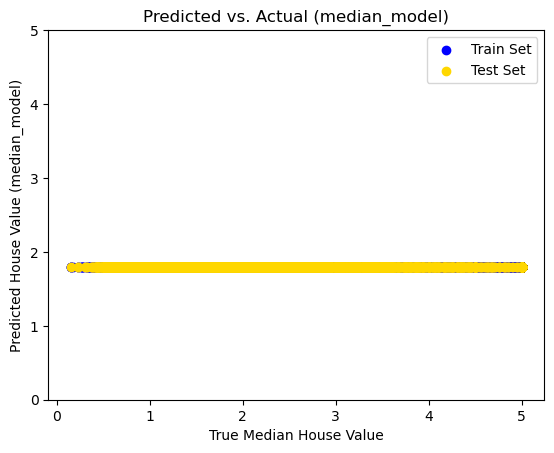

In [17]:
# your code here - `median_model`

# set true y
y = cal_df_train['MedHouseVal']

# Build (crappy) Model
median_model__y_hat_train = np.full(len(cal_df_train), np.median(cal_df_train['MedHouseVal'])) # create array of size train_n with values all median 
assert np.size(median_model__y_hat_train) == n - test_n

# 1) Report the RMSE of train
median_model__rmse_train = compute_rmse(median_model__y_hat_train, cal_df_train['MedHouseVal'])
print(f"train RMSE: {median_model__rmse_train: .3f}")

# 2) Report RMSE
median_model__y_hat_test = np.full(len(cal_df_test),np.median(cal_df_train['MedHouseVal']))
median_model__rmse_test = compute_rmse(median_model__y_hat_test, cal_df_test['MedHouseVal'])
print(f"test RMSE:  {median_model__rmse_test: .3f}")

# 3) How do they compare
    # The train error is actually smaller than the test error. This is somewhat unexpected since the model is only using the data from the training set.
    # However, since the test set is smaller,...

# 4) Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicrted values for the test data?
t_start = time.time()
median_model__y_hat_test = np.full(len(cal_df_test), np.median(cal_df_train['MedHouseVal']))

t2 = time.time() - t_start
print(f"test set predicted in {t2:.6f} seconds") # This is just the amount of time to access MedHouseVal, calculate the median and create the array.
# I assume np.median is the slowest part of this since it has to run in test_n time

# 5) Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. 
    # Color the training instances in blue and test instances in gold. Make sure to albel your axes appropriately, and add a legend to your figure

plt.figure(0)
plt.scatter(cal_df_train['MedHouseVal'], median_model__y_hat_train, color='blue', label = 'Train Set')
plt.scatter(cal_df_test['MedHouseVal'], median_model__y_hat_test, color = 'gold', label = 'Test Set')
plt.xlabel('True Median House Value')
plt.ylabel('Predicted House Value (median_model)')
plt.legend()
plt.title('Predicted vs. Actual (median_model)')
plt.ylim(0, max(cal_df['MedHouseVal']))
plt.show()


*your answer here*

See comments above. This model is unsurprisingly fairly innacurate and thus the plot is both difficult and easy to interpret

### 1.4 Use another baseline for prediction, and compute RMSE [extra-credit]

Now consider a baseline model that predicts median house values as the averages of `MedHouseVal` based on whether the census block is adjacent to the coast or inland (note that the `Inland` feature is already computed and ready for you).

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of block groups in the **training set** that have the same adjacency value.

For example, for an input observation where `Inland==1`, the model should predict the `MedHouseVal` as the average of all `MedHouseVal` values in the training set that also have `Inland==1`.

Once the model is built, do the following:

1. Compute the RMSE of the training set.
2. Now compute the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?
5. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in gold. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
6. Compare this results to those obtained in 1.3. Is coast adjacency improving the predictions? 

*Note:* The `groupby` operation might come handy here.

train RMSE:   1.018
test RMSE:   0.984
test set predicted in 0.000294 seconds


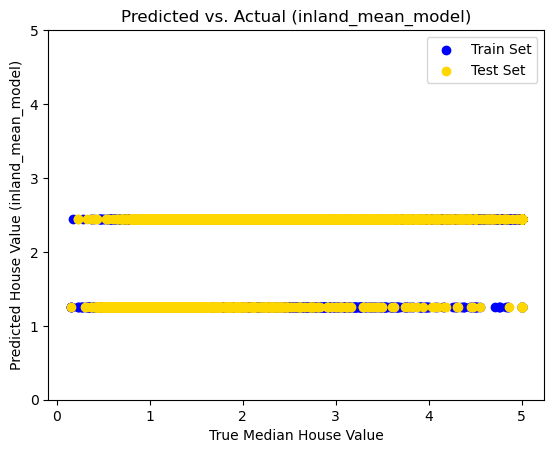

In [18]:
# your code here - `inland_mean_model`

# "train" model using groupby means
inland_mean_model__y_hat = (
    cal_df_train
    .groupby('Inland')
    .mean()
    ['MedHouseVal']
    .to_dict()
)

# predict y_hat_train/test using model
inland_mean_model__y_hat_train = cal_df_train['Inland'].map(inland_mean_model__y_hat)
inland_mean_model__y_hat_test = cal_df_test['Inland'].map(inland_mean_model__y_hat)

# 1) Compute RMSE of training set
inland_mean_model__rmse_train = compute_rmse(inland_mean_model__y_hat_train, cal_df_train['MedHouseVal'])
print(f"train RMSE:  {inland_mean_model__rmse_train: .3f}")

# 2) Compute RMSE of test set
inland_mean_model__rmse_test = compute_rmse(inland_mean_model__y_hat_test, cal_df_test['MedHouseVal'])
print(f"test RMSE:  {inland_mean_model__rmse_test: .3f}")

# 3) Again the test set has a lower error than the train set. Again this is generally unexpected in most cases, but here, with such a simple,
    # and brute-force model, the marginal difference between the sets is not really surprising.

# 4) Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicrted values for the test data?
t_start = time.time()
inland_mean_model__y_hat_test = np.full(len(cal_df_test), cal_df_test['Inland'].map(inland_mean_model__y_hat))

t2 = time.time() - t_start
print(f"test set predicted in {t2:.6f} seconds") # the same as before. Note: This ignores the actual model training, is that fine? TODO

# 5) Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. 
    # Color the training instances in blue and test instances in gold. Make sure to albel your axes appropriately, and add a legend to your figure

plt.figure(1)
plt.scatter(cal_df_train['MedHouseVal'], inland_mean_model__y_hat_train, color='blue', label = 'Train Set')
plt.scatter(cal_df_test['MedHouseVal'], inland_mean_model__y_hat_test, color = 'gold', label = 'Test Set')
plt.xlabel('True Median House Value')
plt.ylabel('Predicted House Value (inland_mean_model)')
plt.legend()
plt.title('Predicted vs. Actual (inland_mean_model)')
plt.ylim(0, max(cal_df['MedHouseVal']))
plt.show()

*your answer here*
6) Compare to 1.3

The avg error did go down, and we can see in the scatter plot that is largely because there is more specificity in the model as the appears to be real separation in the mean values for each group. This is still a very basic and simplistic model though.

---

# Part II: Nearest Neighbors and Cross-Validation
Let's try and build a machine learning algorithm to beat the "Average Values" baselines that you computed above. Your next task is to implement a basic nearest neighbor algorithm from scratch. 

### 2.1 Nearest Neighbors: Normalization

Create normalized analogues of all the features in both the training and test datasets. Recall that this involves substracting the **training** mean and dividing by the **training** standard deviation. 

Include the normalized features as additional columns in the train an test dataframes and call them 
`MedIncNorm, HouseAgeNorm, AveRoomsNorm, AveBedrmsNorm, PopulationNorm, AveOccupNorm, DistCoastNorm and InlandNorm` respectively.

In [19]:
# your code here
cal_df_train__normalized = cal_df_train.apply(lambda x: (x - np.nanmean(x)) / np.nanstd(x)).rename(columns = lambda x: x + 'Norm')
# (cal_df_train - cal_df_train.mean()) / cal_df_train.std() <- after looking it up, apparently this works too since pandas automatically applies colum-wise
cal_df_train__with_norm = pd.merge(cal_df_train, cal_df_train__normalized, left_index=True, right_index=True)
cal_df_train__with_norm = cal_df_train__with_norm.drop('MedHouseValNorm', axis=1)
cal_df_train__with_norm

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,DistCoast,Inland,MedHouseVal,MedIncNorm,HouseAgeNorm,AveRoomsNorm,AveBedrmsNorm,PopulationNorm,AveOccupNorm,DistCoastNorm,InlandNorm
0,3.6885,49,5.184569,1.052950,2363,3.574887,4205.460788,0,2.540,-0.094528,1.614572,-0.097958,-0.091654,0.826997,0.045167,-0.734555,-0.675873
1,3.5444,12,4.786854,1.027230,2029,1.905164,72365.363970,1,1.325,-0.170394,-1.318462,-0.265956,-0.146872,0.533643,-0.103242,0.665384,1.479568
2,4.2011,9,6.045161,1.038710,1955,3.153226,166848.071800,1,1.081,0.175346,-1.556276,0.265564,-0.122226,0.468648,0.007688,2.605970,1.479568
3,3.1630,26,4.267241,0.961207,719,3.099138,28060.624020,0,1.794,-0.371194,-0.208666,-0.485446,-0.288616,-0.616937,0.002881,-0.244593,-0.675873
4,4.6197,21,3.701933,1.019329,1489,1.514751,5593.110112,0,3.875,0.395732,-0.605022,-0.724238,-0.163835,0.059358,-0.137943,-0.706054,-0.675873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20632,2.9119,45,4.796020,0.860697,613,3.049751,5750.389617,0,2.289,-0.503394,1.297487,-0.262085,-0.504400,-0.710038,-0.001509,-0.702824,-0.675873
20633,3.4453,37,4.834667,1.050667,1100,2.933333,44519.806300,0,1.767,-0.222569,0.663318,-0.245760,-0.096556,-0.282303,-0.011856,0.093463,-0.675873
20635,2.8237,34,5.203822,1.019108,1906,3.035032,22623.786330,1,1.107,-0.549830,0.425504,-0.089825,-0.164308,0.425611,-0.002817,-0.356260,1.479568
20636,5.0526,36,6.088496,1.015487,1211,2.679204,22498.581590,0,2.698,0.623646,0.584046,0.283869,-0.172083,-0.184811,-0.034444,-0.358832,-0.675873


### 2.2 Basic Nearest Neighbor algorithm

Use your training data to "fit" your model that predicts `MedHouseVal` from `MedIncNorm`, `HouseAgeNorm` and `AveRoomsNorm`, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the `MedHouseVal` value of the closest training instance. Have your function take L as an input, where L is an integer >= 1 representing the norm choice. Use the Euclidean distance (L=2) for all questions henceforth unless explicitly stated otherwise.

Make sure to do the following - 
1. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
2. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
3. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis.
4. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
5. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4? Explain the

**Note:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

In [23]:
# your code here

train_cols = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm']

def euclidean_distance(x, y, L = 2):
    x_ = np.array(x)
    y_ = np.array(y)
    
    return np.power(np.sum(np.power(np.abs(x_-y_), L)), 1/L)

euclidean_distance(np.array([2,3,4]), np.array([5, 2, 3]), 1)
euclidean_distance([2,3,4], [5, 2, 3], 2)


def knn(data, k, cols = None, distance_metric = euclidean_distance, **kwargs):
    # Param Handling

    # Algorithm

    ## given unlabeled data x_j, distance func D(*), find K nearest neighbors, X_1,...X_k
    ## - predict f(x_j) = \sum(y_k) \forall k 1->K

    ## for each instance (data[cols])
    ## 

    print(distance_metric(data['MedIncNorm'], data['HouseAgeNorm']))

#euclidean_distance(cal_df_train__with_norm['MedIncNorm'], cal_df_train__with_norm['HouseAgeNorm'])

knn(cal_df_train__with_norm, 2)


centers = [np.array([0,0,0]), np.array([1,1,1]), np.array([-1,-1,-1])]
for c in centers:
    print(f"{c}: {euclidean_distance(c, cal_df_train__with_norm.loc[1, train_cols])}")


#map(centers, euclidean_distance, cal_df_train__with_norm.loc[1, train_cols])


# create K centers
# dists = np.matrix


185.44725402755438
[0 0 0]: 1.3557692050270473
[1 1 1]: 2.889244936718336
[-1 -1 -1]: 1.1525987897992966


In [38]:
K = 3
distance_array = np.zeros([K,cal_df_train__with_norm.shape[0]])

#cal_df_train__with_norm[train_cols].apply(lambda x: euclidean_distance(x, pd.DataFrame(centers)), axis = 1)

#list(map(np.vectorize(euclidean_distance), centers, cal_df_train__with_norm[train_cols]))

#np.apply_over_axes(euclidean_distance, np.matrix(centers), cal_df_train__with_norm[train_cols].head(3), 1)

# (
#     cal_df_train__with_norm[train_cols]
#     .apply(lambda x: min(euclidean_distance(x, pd.DataFrame(centers))), axis = 1)
# )

#euclidean_distance(cal_df_train__with_norm.loc[0, train_cols], centers[0] + centers[1] + centers[2])

# for row in cal_df_train__with_norm[train_cols].head(3):
#     print(row)
    # for c in centers:
    #     print(row)
    #     print(c)
    #     print(euclidean_distance(row, c))


centers_df = pd.DataFrame(centers)
cal_df_train__with_norm__dists = (
    cal_df_train__with_norm[train_cols]
    .apply(lambda x: centers_df.apply(lambda y: euclidean_distance(x, y), axis = 1), axis = 1)
)

cal_df_train__with_norm__dists['k'] = cal_df_train__with_norm__dists.idxmin(axis = 1)
display(cal_df_train__with_norm__dists)

# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[0,train_cols]), centers[0]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[0,train_cols]), centers[1]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[0,train_cols]), centers[2]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[1,train_cols]), centers[0]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[1,train_cols]), centers[1]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[1,train_cols]), centers[2]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[2,train_cols]), centers[0]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[2,train_cols]), centers[1]))
# print(euclidean_distance(np.array(cal_df_train__with_norm.loc[2,train_cols]), centers[2]))

,0,1,2,k
0,1.620301,1.667694,2.910248,0
1,1.355769,2.889245,1.152599,2
2,1.588479,2.784600,1.814534,0
3,0.645743,2.355334,1.134184,0
4,1.023316,2.431919,1.476523,0
...,...,...,...,...
20632,1.416181,1.985334,2.463653,0
20633,0.741569,1.777624,1.984919,0
20635,0.701024,1.979833,1.750181,0
20636,0.900348,0.909672,2.606482,0


*your answer here*

### 2.3 Optimization

Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L! Use the test set to report the RMSE values.

What combination of features and distance function provide the lowest RMSE on the test set?  Do your decisions affect the running time of the algorithm?

**Note:** For this and all subsequent questions, you should use normalized features. 

In [ ]:
# your code here

*your answer here*

### 2.4 K-nearest neighbors algorithm

Now, implement the K-nearest neighbors algorithm and repeat the analysis in 2.2 by using 5 neighbors (`K=5`). The function(s) you write here will be used several more times in this problem set, so do your best to write efficient code! Make sure to do the following:
1. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
2. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
3. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis.
4. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
5. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

**Note:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

In [ ]:
# your code here

*your answer here*

### 2.5 Cross-Validation

How can we choose K without overfitting? As discussed during lecture time, one possible solution is to use [k-fold cross-validation][1] on the training sample.  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function(s) you write here will be used several more times in this problem set, so do your best to write efficient code! 

Use 20-fold cross-validation and report the average RMSE for your K-nearest neighbors model using Euclidean distance with the same set of features used in 2.4 (`MedIncNorm, HouseAgeNorm and AveRoomsNorm`) and 5 neighbors (`K=5`)  as well as the total running time for the full run of 20 folds.  

In other words, randomly divide your training dataset (created in 1.2) into 20 equally-sized samples. For each of the 20 iterations (the "folds"), use 19 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for validation.  Compute the RMSE of that particular validation set, then move on to the next iteration.  

 - Report the average cross-validated RMSE across the 20 iterations and compare to the result you obtained in 2.3. What do you observe?
 - Report the runtime of your algorithm.How does it compare to your previous results?

[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

**Note 1:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

**Note 2**: The sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.

**Note 3:** To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [ ]:
# your code here

*your anwer here*

### 2.6 Using cross validation to find the optimal value for K

Compute the cross-validated RMSE for values of K between 1 and 25 using 10-fold cross-validation and L2 normalization.  Use the following features in your model: `MedIncNorm, HouseAgeNorm and AveRoomsNorm` .  Create a graph that shows how cross-validated RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

Finally, "train" a K-nearest neighbor model using the value of K that minimized the cross-validated RMSE and report the test RMSE. (Continue to use L2 normalization and the same set of features). How does the test RMSE compare to the cross-validated RMSE, and is this what you expected? 

**Note:** Runtime should not exceed ~30 min. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

In [ ]:
# your code here

*your answer here*

---

# Part III: Overfitting in Model Selection and Nested Cross Validation 


In this last part of the problem set, we will examine why overfitting is a serious concern when estimating hyperparameters and how to address it. 

**For this part of the problem set you are allowed to use machine learning libraries. We don't expect you to use your own algorithms developed in part 2.** We strongly suggest that you use the following libraries and resources, but feel free to choose your favorite Python ML libraries.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import joblib

For this part of the problem set we will no longer be using the California Housing Dataset. Instead, we will generate our own synthetic data. The advantage of doing so is that we get to choose the data generating process. We will use the knowledge about the data generating process to test the robustness of different approaches to estimating out-of-sample performance.

We will attempt the following classification problem: predict a binary response variable $y \sim Bernoulli(p=1/2)$ from a set of independent features $X=[x_{1},...,x_{J}]$ where $x_{j} \sim Unif(a=0,b=1)$, $1 \leq j \leq J$. 

You can use the following function to generate samples from this distribution.

In [ ]:
def generate_random_sample(nobs,J):
    X = pd.DataFrame(np.random.random_sample(size=(nobs, J)), columns=[f'feature_{x}' for x in range(J)])
    y = np.random.binomial(n=1,p=1/2,size=nobs)
    return X,y

X_train,y_train = generate_random_sample(nobs=2*10**3,J=100)

### 3.1 Out-of-sample performance

We are going to be using the area under the ROC curve (AUC-ROC) as the evaluation score. What kind of out-of-sample performance would you expect from classification models trained and tested on this data? Test whether your intuition is correct by carrying out the following iterative procedure:

1. For each iteration in 1,2,3,...,50:
    * Generate a training sample containing 2,000 observations and J=100 features. Likewise, generate a test sample containing 200 observations and J=100 features. 
    * Train some K-nearest neighbors model on the training sample with some arbitrary choice of K (no need to cross validate the choice of K or put any work into it, we'll get to that later on).
    * Evaluate the AUC-ROC on the test set.
2. Plot a histogram of the test AUC-ROC scores.
3. Report the average of the test AUC-ROC scores.

In [ ]:
# your code here

*your answer here*

### Fix a sample

In real life settings we wouldn't be able to draw test and train samples at will. For the rest of the pset (3.2-3.6) we will fix a training and test sample:

In [ ]:
X_train,y_train = generate_random_sample(nobs=2*10**3,J=100)
X_test,y_test = generate_random_sample(nobs=2*10**2,J=100)

### 3.2 k-fold cross-validation 
Use 10-fold cross-validation on the train sample to find the optimal K and report the hyperparameter value. Report also the average of the cross validated scores for the optimal hyperparameter value. 

In [ ]:
# your code here

### 3.3 Nested cross-validation

Use nested cross validation ([3],[4],[5],[6]) on the training sample. In the outer loop you should be estimating model performance and in the inner loop you should be doing regular k-fold cross validation to find the optimal K. Use 10 folds for the inner cv and 3 folds for the outer cv. Report the average of the cross-validated scores of the outer loop.

[3]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py
[4]: https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html#:~:text=As%20a%20conclusion%2C%20when%20optimizing,validation%20are%20often%20overly%20optimistic.
[5]: https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection/65156#65156
[6]: https://stats.stackexchange.com/questions/232897/how-to-build-the-final-model-and-tune-probability-threshold-after-nested-cross-v/233027#233027

In [ ]:
# your code here

### 3.4 Take stock of the results so far

Based on the results of 3.1, 3.2 and 3.3, what can you say about estimating out-of-sample performance? Is the average of the cross-validated scores a good estimator? How about the average of the nested cross-validated scores? Are they underestimating or overestimating true out-of-sample performance?

*your answer here*

### 3.5 Comparing k-fold and nested cross-validation [extra-credit]

We would like to better assess the difference between the k-fold and nested cross-validation scores and make sure that the results we observed in 3.2 and 3.3 are not a fluke. To do this, repeat both experiments 50 times. In each iteration, pass a different value for the "random_state" parameter in the KFold function to ensure that there is variation in the fold splitting. 

In a single figure, plot two histograms. One showing the distribution of the k-fold scores, another showing the distribution of the nested scores. Use gold for the color of the objects related to the nested scores and blue for the color of the objects related to the k-fold scores. 

**Note 1**: you should NOT be generating a new sample -- continue working with the dataset fixed ahead of question 3.2.

**Note 2**: Runtime should not exceed 30 min. If its taking longer then we strongly suggest you go back to your code and make it more efficient.

In [ ]:
# your code here

### 3.6 Conclusion [extra-credit]

Based on the figure from 3.5, would you adjust your answer to question 3.4? In a couple of sentences, explain why overfitting can arise when doing model selection, and why nested cross-validation is a useful tool in preventing it. 

*your answer here*